In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.datasets
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns

### Nacitaj tvare

In [2]:
# ziskavanie ciest k suborom s fotografiami
_, _, files = list(os.walk("photos64"))[0]

faces = dict()

# nacitanie fotografii
for f in files:
    f.encode('unicode_escape')
    img = cv2.imread("photos64/"+f)
    # zmena farebnosti z farebnych na grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces[f] = gray

### Nacitanie trenovacieho dataset

In [3]:
# nacitanie trenovacich tvary z datasetu Olivetti 
images = sklearn.datasets.fetch_olivetti_faces()["images"]

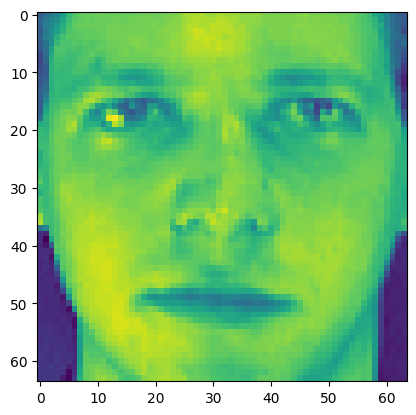

In [4]:
# ukazaka fotografie z tohto datasetu
plt.imshow(images[0])

### Priemerna tvar

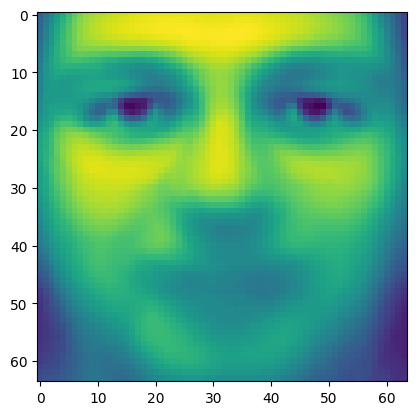

In [5]:
avg_face = np.zeros(64*64)    
# vypocet suctu vsetkych tvari
for face in images:
    # zmena rozmerov, z fotografie na vektor
    face_vec = face.flatten()
    avg_face += face_vec

# vydelenie poctom pre ziskanie priemernej tvare
avg_face = avg_face/len(faces)

#vykreslenie priemernej tvare
avg_face_img = avg_face.reshape(64, 64)
plt.imshow(avg_face_img)

### Rozdielny trenovacich oproti priemernej tvary

In [6]:
# vypocet rozdiel trenovacich tvari od priemernej tvare
face_train_diffs = list()
for face in images:
    face_vec = face.flatten()
    face_train_diffs.append(face_vec - avg_face)

### Vypocitaj eigenfaces

In [7]:
# vytvorenie matice obsahujucej vektory forografii ako stlpce
A = np.matrix([i for i in face_train_diffs]).T
# vypocet matice (A^T)*(A)
AtA = np.matmul(A.T, A)
# vypocet eigenvektor matice (A^T)*(A)
_, vec = np.linalg.eigh(AtA)
# vypocet eigenfaces pre maticu A
eigen = np.array([np.array(np.matmul(A, v.T).T)[0] for v in vec]).T

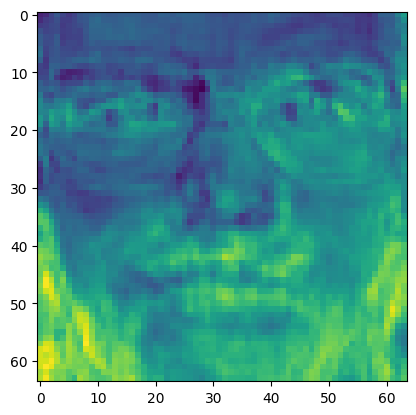

In [8]:
# ukazka jeden eigenface
plt.imshow(eigen.T[1].reshape(64, 64))

### Rozdielny nasich oproti priemernej tvary

In [9]:
#vypocet rozdielu nasich footgrafii od trenovacej priemernej tvare
face_diffs = dict()
for name, face in faces.items():
    face_vec = face.flatten()
    face_diffs[name] = face_vec - avg_face

### Vypocitaj koeficienty eigenfaces pre jednotlive tvare

In [10]:
%%time
# vypocet koeficientov eigenfaces pre jednotlive nase fotografie
face_vals = dict()
for name, face in face_diffs.items():
    face_vals[name] = np.linalg.lstsq(eigen, face, rcond=None)[0]

CPU times: total: 42.1 s
Wall time: 2min 31s


### Hľadanie lakťa na celych dátach

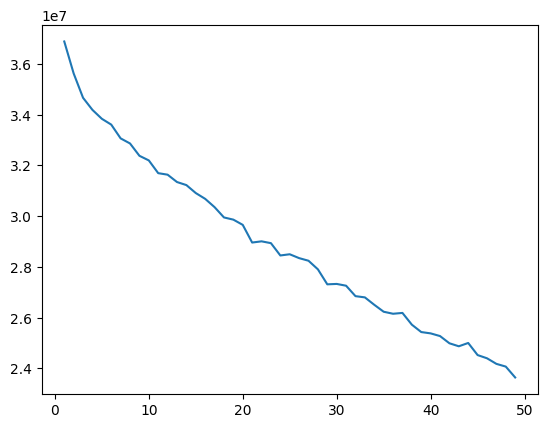

In [11]:
# snaha najst "elbow" pre kmeans cize pocet kluster kde sa rychlosť poklesu chybu vyrazne spomaly
iner = []
rang = list(range(1,50))
for i in rang:
    kmeans = KMeans(n_clusters=i, random_state=3, algorithm="lloyd").fit(list(face_vals.values()))
    iner.append(kmeans.inertia_)

# vykreslenie valkosti chyby vzladok na pocet klustrov
plt.plot(rang, iner)

In [12]:
# hladanie najpodobnejsej tvare ku kazdej tvary pomocou Euklidovksej vzialenosti 
# rozdielu vektorou koeficientou eigenfaces
for name1, val1 in face_vals.items():
    # zapamatanie zatial najlepsej tvare
    best_dist = float("inf")
    best_name = ""
    for name2, val2 in face_vals.items(): 
        # ak najde lepsiu nahradi nou zatial najlepsiu
        if name1 != name2 and np.linalg.norm(val1 - val2) < best_dist:
            best_dist = np.linalg.norm(val1 - val2)
            best_name = name2
    #print("Najpodobnejsia tvar k", name1, "je", best_name, best_dist)
    print(f"{name1:42} {best_name:42} {best_dist:1.18}")
            
        

AIN extra_Alexander Simko_align.jpg        AIN_Igor Farkas_align.jpg                  320.439007524337853
AIN extra_Andrej Lucny_align.jpg           KJFB_Stanislav Tokar DrSc_align.jpg        461.696679839272292
AIN extra_Barbora Cimrova_align.jpg        KAFZM_Martin Gera PhD_align.jpg            332.796821833227227
AIN extra_Damas Gruska_align.jpg           KTF_Eduard Masar CSc_align.jpg             432.939232470253614
AIN extra_Dusan Guller_align.jpg           AIN_Jozef Siska_align.jpg                  299.130890717419902
AIN extra_Frantisek Gyarfas_align.jpg      KEF_Zuzana Zabudla_align.jpg               289.7991250488368
AIN extra_Jan Komara_align.jpg             KAFZM_Martin Gera PhD_align.jpg            470.3728970314055
AIN extra_Lubica Benuskova_align.jpg       AIN_Maria Lucka_align.jpg                  471.989080007253619
AIN extra_Maria Markosova_align.jpg        KAFZM_Peter Jevcak_align.jpg               509.781613937963186
AIN extra_Martin Takac_align.jpg           AIN ext

### Zmensenie dimenzie pomocou Principal Component Analysis

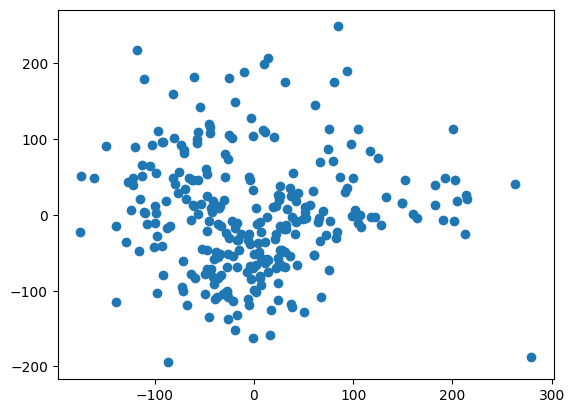

In [13]:
# znizenie dimenzionality vektorou koeficientou eigenfaces pomocou petody PCA na 2 dimenzie
pca = PCA(n_components=2).fit_transform(list(face_vals.values()))

# vykreslenie scatterplotu vysledkych hodnot
plt.scatter(x=pca[:, 0], y=pca[:, 1])

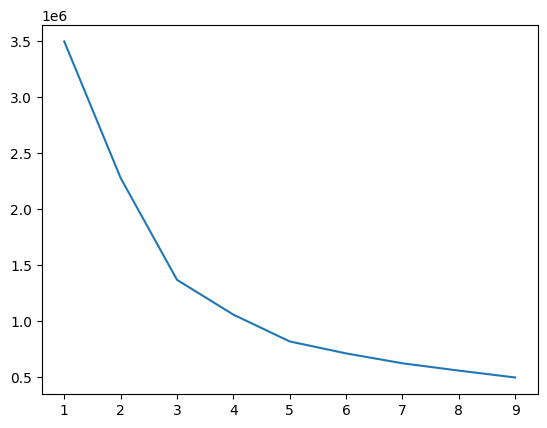

In [14]:
# snaha o kladanie "elbow" pre data so znizenou dimenziou
iner = []
rang = list(range(1,10))
for i in rang:
    kmeans = KMeans(n_clusters=i, random_state=0, algorithm="lloyd").fit(pca)
    iner.append(kmeans.inertia_)

# vykreslenie valkosti chyby vzladok na pocet klustrov
plt.plot(rang, iner)

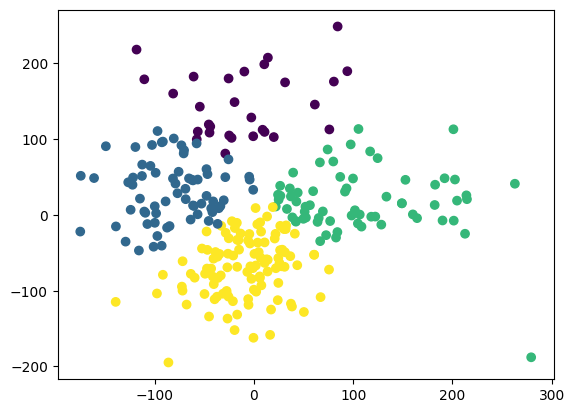

In [20]:
# vykreslenie dat ofarbenych podla znaciek 
kmeans = KMeans(n_clusters=4, random_state=0, algorithm="lloyd").fit(pca)
plt.scatter(x=pca[:, 0], y=pca[:, 1], c=kmeans.labels_)

### Zmensenie dimenzie pomocou Singular Value Decomposition

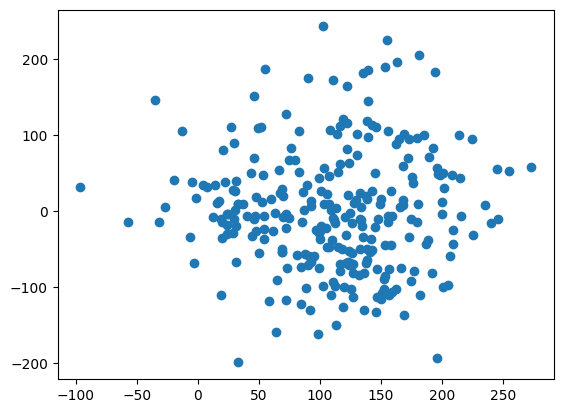

In [16]:
# znizenie dimenzionality vektorou koeficientou eigenfaces pomocou petody SVD na 2 dimenzie
svd = TruncatedSVD(n_components=2).fit_transform(list(face_vals.values()))

# vykreslenie scatterplotu vysledkych hodnot
plt.scatter(x=svd[:, 0], y=svd[:, 1])

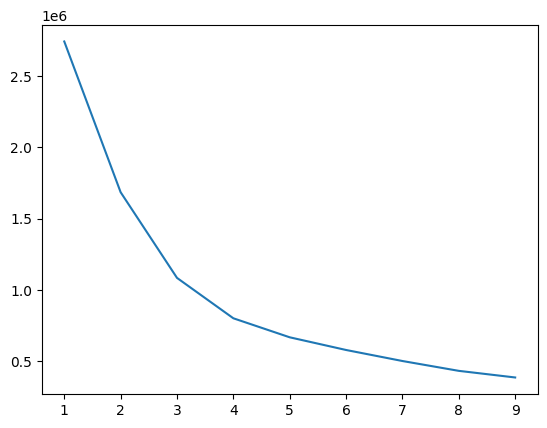

In [17]:
# snaha o kladanie "elbow" pre data so znizenou dimenziou
iner = []
rang = list(range(1,10))
for i in rang:
    kmeans = KMeans(n_clusters=i, random_state=3, algorithm="lloyd").fit(svd)
    iner.append(kmeans.inertia_)

# vykreslenie valkosti chyby vzladok na pocet klustrov
plt.plot(rang, iner)

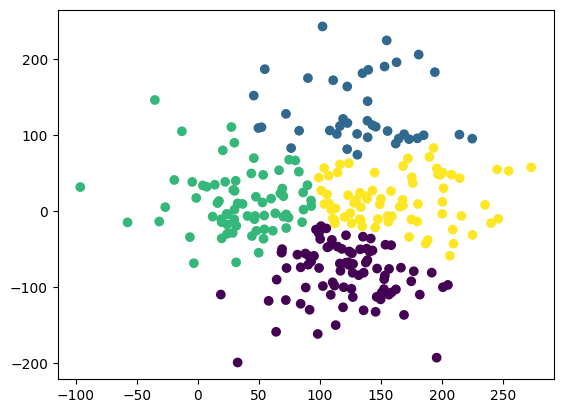

In [19]:
# vykreslenie dat ofarbenych podla znaciek 
kmeans = KMeans(n_clusters=4, random_state=0, algorithm="lloyd").fit(svd)
plt.scatter(x=svd[:, 0], y=svd[:, 1], c=kmeans.labels_)